# Using Built-in Callbacks


## Libraries

In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import keras
import numpy as np

## Simple NN Model

In [3]:
def create_model():
    model = keras.Sequential([
        keras.layers.Input(shape=(784,)),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(10, activation="softmax")
    ])
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = create_model()

## Dataset

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 784).astype("float32") / 255.0
x_test = x_test.reshape(-1, 784).astype("float32") / 255.0


## Built-in Callbacks

In [7]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',  # Monitor validation loss
        patience=3,          # Stop if no improvement for 3 epochs
        verbose=1,           # Log when stopping
        restore_best_weights=True # Revert to weights from the best epoch
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="best_model_weights.keras", # Path to save model weights
        monitor="val_accuracy", # Monitor validation accuracy
        save_best_only=True, # Save only the best performing model
        mode="max", # max in order to maximize accuracy
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", # Monitor validation loss
        factor=0.2, # Reduce learning rate by a factor of 0.2
        patience=2, # If no improvement for 2 epochs
        min_lr=0.0001, # Minimum learning rate
        verbose=1
    )
]

## Training With Built-in Callbacks

In [8]:
print("\nStarting training with built-in callbacks...")
history = model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(x_test, y_test),
    callbacks=callbacks,
    verbose=0
)
print("Training finished")


Starting training with built-in callbacks...

Epoch 1: val_accuracy improved from -inf to 0.97890, saving model to best_model_weights.keras

Epoch 2: val_accuracy improved from 0.97890 to 0.97950, saving model to best_model_weights.keras

Epoch 3: val_accuracy did not improve from 0.97950

Epoch 4: val_accuracy did not improve from 0.97950

Epoch 5: val_accuracy did not improve from 0.97950
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
Training finished



Generating training plots...


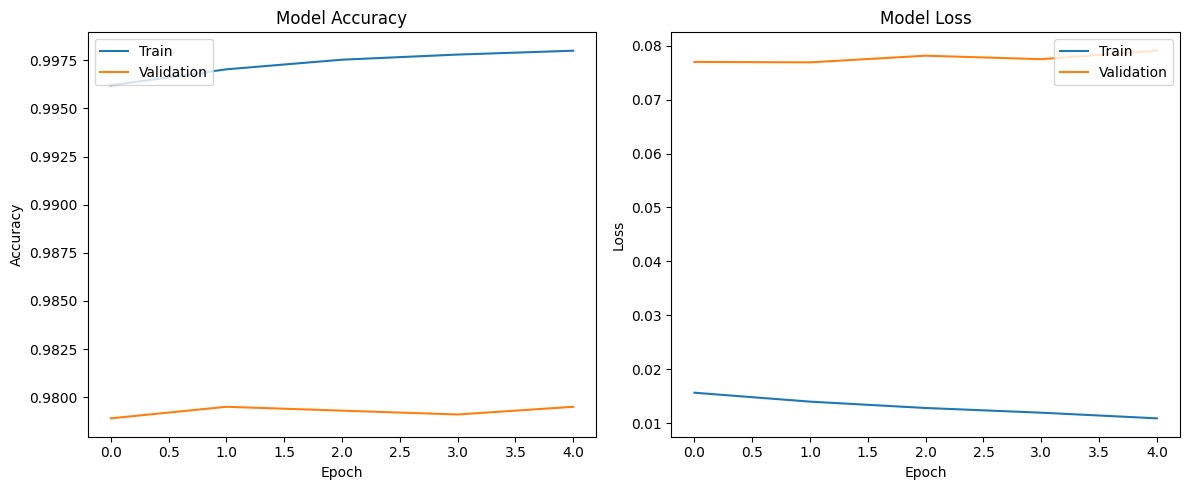

In [12]:
import matplotlib.pyplot as plt

# Plotting the training history
print("\nGenerating training plots...")
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

## Inference

In [18]:
inference_model = create_model()
best_weights_filepath = 'best_model_weights.keras'

try:
    print(f"Loading best weights from: {best_weights_filepath}...")
    inference_model.load_weights(best_weights_filepath)
    print("Weights loaded successfully!")
except Exception as e:
    print(f"Error loading weights: {e}")
    print("Please ensure 'best_model_weights.keras' exists and the model architecture matches.")

# Take the first 5 test samples for demonstration
sample_images = x_test[:5]
true_labels = y_test[:5]

# Perform inference (make predictions)
print("\nPerforming inference on sample data...")
predictions = inference_model.predict(sample_images)

# Interpret the predictions
predicted_classes = np.argmax(predictions, axis=1)

print("\n--- Inference Results ---")
for i in range(len(sample_images)):
    print(f"Sample {i+1}:")
    print(f"  True Label: {true_labels[i]}")
    print(f"  Predicted Label: {predicted_classes[i]}")
    print(f"  Prediction Probabilities: {predictions[i].round(2)}") # Display probabilities
    print("-" * 25)

# You can also evaluate the loaded model on the full test set
print("\nEvaluating the loaded model on the full test set...")
loss, accuracy = inference_model.evaluate(x_test, y_test, verbose=0)
print(f"Model Loss on Test Set: {loss:.4f}")
print(f"Model Accuracy on Test Set: {accuracy:.4f}")

Loading best weights from: best_model_weights.keras...
Weights loaded successfully!

Performing inference on sample data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

--- Inference Results ---
Sample 1:
  True Label: 7
  Predicted Label: 7
  Prediction Probabilities: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
-------------------------
Sample 2:
  True Label: 2
  Predicted Label: 2
  Prediction Probabilities: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
-------------------------
Sample 3:
  True Label: 1
  Predicted Label: 1
  Prediction Probabilities: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
-------------------------
Sample 4:
  True Label: 0
  Predicted Label: 0
  Prediction Probabilities: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-------------------------
Sample 5:
  True Label: 4
  Predicted Label: 4
  Prediction Probabilities: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
-------------------------

Evaluating the loaded model on the full test set...
Model Loss on Test Set: 0.0769
Model Accuracy on Test Set: 0.9795


# Custom Callbacks

## Logs

In [24]:
import json

class ExternalMetricLogger(keras.callbacks.Callback):
    def __init__(self, log_file="external_metrics_log.json"):
        super().__init__()
        self.log_file = log_file
        self.all_logs = [] # To store all epoch logs

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Prepare data to be sent, including epoch number
        log_data = {
            "epoch": epoch + 1,
            "metrics": {k: float(v) for k, v in logs.items()} # Convert to float for JSON compatibility
        }
        self.all_logs.append(log_data)

        # In a real scenario, you'd send this 'log_data' to an external API
        # or database. For this example, we'll just print it.
        print(f"\n--- Sent to External System (Epoch {epoch + 1}): {json.dumps(log_data)} ---")

    def on_train_end(self, logs=None):
        # Optionally, save all logs to a file at the end of training
        with open(self.log_file, 'w') as f:
            json.dump(self.all_logs, f, indent=4)
        print(f"\nAll training logs saved to {self.log_file}")

In [25]:
model = create_model()
external_logger_callback = ExternalMetricLogger()

print("\nStarting training with External Metric Logger Callback...")
history = model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(x_test, y_test),
    callbacks=[external_logger_callback],
    verbose=0
)
print("Training finished.")


Starting training with External Metric Logger Callback...

--- Sent to External System (Epoch 1): {"epoch": 1, "metrics": {"accuracy": 0.9184166789054871, "loss": 0.2821539342403412, "val_accuracy": 0.9545999765396118, "val_loss": 0.1521143913269043}} ---

--- Sent to External System (Epoch 2): {"epoch": 2, "metrics": {"accuracy": 0.9629666805267334, "loss": 0.12445816397666931, "val_accuracy": 0.9663000106811523, "val_loss": 0.1091393530368805}} ---

--- Sent to External System (Epoch 3): {"epoch": 3, "metrics": {"accuracy": 0.9720500111579895, "loss": 0.09056292474269867, "val_accuracy": 0.9692000150680542, "val_loss": 0.09991935640573502}} ---

--- Sent to External System (Epoch 4): {"epoch": 4, "metrics": {"accuracy": 0.9779999852180481, "loss": 0.07102259993553162, "val_accuracy": 0.972000002861023, "val_loss": 0.09328478574752808}} ---

--- Sent to External System (Epoch 5): {"epoch": 5, "metrics": {"accuracy": 0.9812166690826416, "loss": 0.0582815445959568, "val_accuracy": 0.97

## Metrics

In [19]:
def custom_f1_score(y_true, y_pred):
    y_true = keras.ops.cast(y_true, 'float32') # Ensure consistent dtype
    y_pred = keras.ops.cast(y_pred, 'float32')

    # For binary classification, you might threshold predictions
    # For multi-class, argmax on y_pred, then compare with y_true
    # Let's simplify for demonstration: treating as binary for simplicity
    y_pred_binary = keras.ops.round(y_pred) # Round to 0 or 1

    true_positives = keras.ops.sum(y_true * y_pred_binary)
    predicted_positives = keras.ops.sum(y_pred_binary)
    possible_positives = keras.ops.sum(y_true)

    precision = true_positives / (predicted_positives + keras.backend.epsilon())
    recall = true_positives / (possible_positives + keras.backend.epsilon())

    f1_score = 2 * (precision * recall) / (precision + recall + keras.backend.epsilon())
    return f1_score

In [21]:
def create_model_with_custom_metric():
    model = keras.Sequential([
        keras.layers.Input(shape=(784,)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid') # Use sigmoid for binary classification example
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy', # Use binary_crossentropy for sigmoid output
                  metrics=['accuracy', custom_f1_score]) # Add our custom F1 score
    return model

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# Let's simplify data for binary classification (e.g., predict if digit is '0')
x_train = x_train.reshape(-1, 784).astype("float32") / 255.0
y_train_binary = (y_train == 0).astype("float32") # 1 if digit is 0, else 0
x_test = x_test.reshape(-1, 784).astype("float32") / 255.0
y_test_binary = (y_test == 0).astype("float32")

model = create_model_with_custom_metric()

print("\nStarting training with custom F1-score metric...")
history = model.fit(
    x_train, y_train_binary,
    epochs=5,
    batch_size=32,
    validation_data=(x_test, y_test_binary),
    verbose=1
)
print("Training finished.")

print("\nHistory with custom metric:")
print(history.history.keys())


Starting training with custom F1-score metric...
Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 885us/step - accuracy: 0.9856 - custom_f1_score: 2.9997 - loss: 0.0523 - val_accuracy: 0.9955 - val_custom_f1_score: 3.0853 - val_loss: 0.0158
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 676us/step - accuracy: 0.9969 - custom_f1_score: 3.1889 - loss: 0.0105 - val_accuracy: 0.9976 - val_custom_f1_score: 3.1116 - val_loss: 0.0091
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/step - accuracy: 0.9985 - custom_f1_score: 3.0995 - loss: 0.0052 - val_accuracy: 0.9914 - val_custom_f1_score: 3.2219 - val_loss: 0.0241
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 608us/step - accuracy: 0.9979 - custom_f1_score: 3.1547 - loss: 0.0055 - val_accuracy: 0.9970 - val_custom_f1_score: 3.1082 - val_loss: 0.0125
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step - accuracy: 0.9987 - custom_f1_score: 3.1297 - loss: 0.0038 - val_accuracy: 0.9976 - val_custom_f1_score: 3.1233 - val_loss: 0.0112
Training finish